In [25]:
# Import Libraries

import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import trange

In [26]:
NUM_FEATURES = 1000
NUM_SAMPLES = 1000
NUM_CLASSES = 50

In [27]:
# Step 1

A = np.random.randn(NUM_SAMPLES, NUM_FEATURES)

X = np.random.randn(NUM_FEATURES, NUM_CLASSES)
W = np.random.randn(NUM_FEATURES, NUM_CLASSES)

E = np.random.randn(NUM_SAMPLES, NUM_CLASSES)

# Not initialising with the same X
B = A.dot(W) + E

In [28]:
Y = np.argmax(B, axis=1) 

# Y one-hot encoding
Y_oh = (B == B.max(axis=1, keepdims=1)).astype(int)

# Second version of one-hot encoding
Y_one_hot = np.zeros((NUM_SAMPLES, NUM_CLASSES))
Y_one_hot[np.arange(NUM_SAMPLES), Y] = 1

In [29]:
def loss(X):
    first_term = (A * X.T[Y]).sum(axis=-1)

    second_term = np.log(np.exp(A.dot(X)).sum(axis=-1))

    return (-first_term + second_term).sum()

In [30]:
def gradient(X):
    AX = A.dot(X)
    soft_max = np.exp(AX) / np.exp(AX).sum(axis=-1, keepdims=True)
    return A.T.dot(soft_max - Y_oh)

In [31]:
# Create copy of X 
X_GD = X.copy()
X_BCGD_R = X.copy()
X_BCGD_GS = X.copy()

In [32]:
# Gradient Descent
max_iter = 500
learning_rate = 0.001

losses = []
times = []
accuracies = []

start_time = time.time()

for i in trange(max_iter):
    X_GD -= learning_rate * gradient(X_GD)
    if i % 1 == 0:
        losses.append(loss(X_GD))
        times.append(time.time() - start_time)
        accuracies.append((Y == np.argmax(A.dot(X_GD), axis=1)).mean())

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:08<00:00, 55.68it/s]


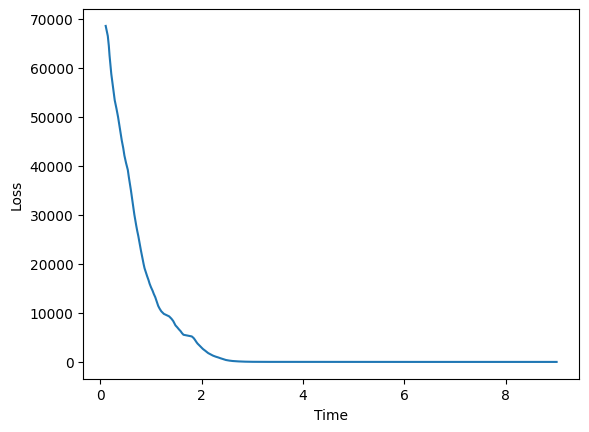

In [33]:
plt.plot(times, losses)
plt.xlabel('Time')
plt.ylabel('Loss')
plt.show()

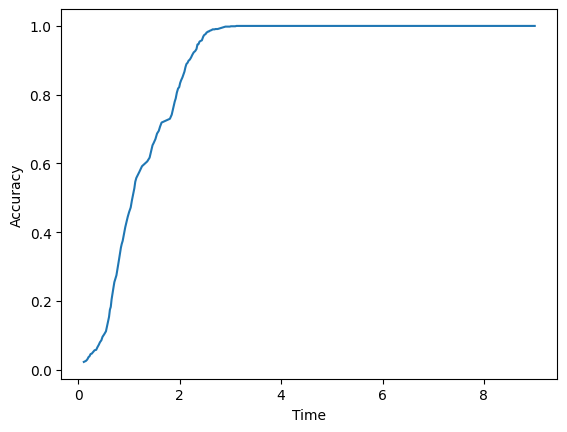

In [34]:
plt.plot(times, accuracies)
plt.xlabel('Time')
plt.ylabel('Accuracy')
plt.show()

In [35]:
# BCGD with Randomized Block Selection

# Gradient on Randomized Block where block is a row of X


def gradient_bcgd(X, block):
    A_j = A[:,block]

    AX = A.dot(X)
    soft_max = np.exp(AX) / np.exp(AX).sum(axis=-1, keepdims=True)
    return A_j.T.dot(soft_max - Y_oh)


In [36]:
# Gradient Descent
max_iter = 500
learning_rate = 0.001

bcgd_r_losses = []
bcgd_r_times = []
bcgd_r_accuracies = []

start_time = time.time()

for i in trange(max_iter):
    for j in range(NUM_FEATURES):
        block = np.random.randint(0, NUM_FEATURES)
        X_BCGD_R[block] -= learning_rate * gradient_bcgd(X_BCGD_R, block)
    if i % 1 == 0:
        bcgd_r_losses.append(loss(X_BCGD_R))
        bcgd_r_times.append(time.time() - start_time)
        bcgd_r_accuracies.append((Y == np.argmax(A.dot(X_BCGD_R), axis=1)).mean())

 80%|████████  | 401/500 [25:07<06:12,  3.76s/it]


KeyboardInterrupt: 

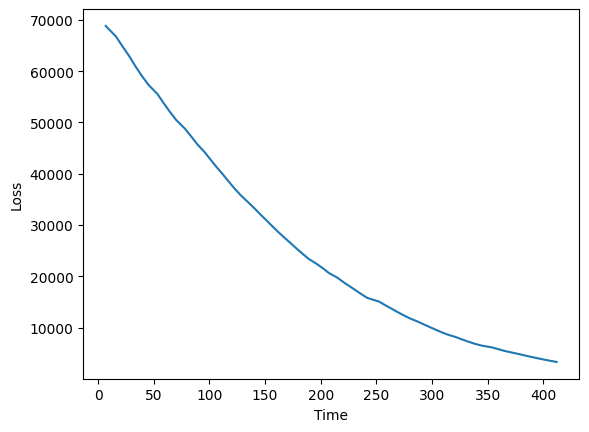

In [ ]:
plt.plot(bcgd_r_times, bcgd_r_losses)
plt.xlabel('Time')
plt.ylabel('Loss')
plt.show()

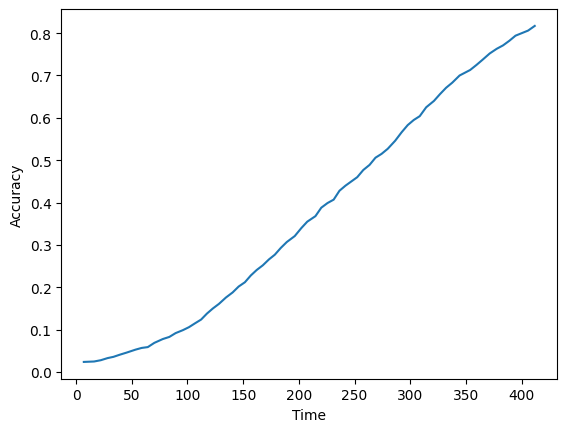

In [ ]:
plt.plot(bcgd_r_times, bcgd_r_accuracies)
plt.xlabel('Time')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
# BCGD with GS Block Selection


# Gradient Descent
max_iter = 500
learning_rate = 0.001

bcgd_gs_losses = []
bcgd_gs_times = []
bcgd_gs_accuracies = []

grad = gradient(X_BCGD_GS)
start_time = time.time()

for i in trange(max_iter):
    for j in range(NUM_FEATURES):
        block = np.argmax(np.linalg.norm(grad))
        X_BCGD_GS[block] -= learning_rate * grad[block]
        # TODO: update full gradient
        
    if i % 1 == 0:
        bcgd_gs_losses.append(loss(X_BCGD_GS))
        bcgd_gs_times.append(time.time() - start_time)
        bcgd_gs_accuracies.append((Y == np.argmax(A.dot(X_BCGD_GS), axis=1)).mean())
